In [1]:
import os
import time
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix



In [2]:
# Load hyperparameters
with open("../experiments/exp2/config.json", "r") as f:
    config = json.load(f)

original_dir = config["original_dir"]
cartoon_dir = config["cartoon_dir"]
batch_size = config["batch_size"]
total_epochs = config["total_epochs"]
lambda_l1 = config["lambda_l1"]
learning_rate = config["learning_rate"]
limit = config["limit"]
beta1 = config["beta1"]
beta2 = config["beta2"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
print(device)

cuda


In [3]:
class CartoonDataset(Dataset):
    def __init__(self, original_dir, cartoon_dir, transform=None, limit=None):
        self.original_paths = sorted(glob(os.path.join(original_dir, '*.png')))
        self.cartoon_paths = sorted(glob(os.path.join(cartoon_dir, '*.png')))
        if limit:
            self.original_paths = self.original_paths[:limit]
            self.cartoon_paths = self.cartoon_paths[:limit]
        self.transform = transform

    def __len__(self):
        return len(self.original_paths)

    def __getitem__(self, idx):
        real = Image.open(self.original_paths[idx]).convert('RGB')
        cartoon = Image.open(self.cartoon_paths[idx]).convert('RGB')
        if self.transform:
            real = self.transform(real)
            cartoon = self.transform(cartoon)
        return real, cartoon


In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.middle = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [7]:
dataset = CartoonDataset(original_dir, cartoon_dir, transform=transform, limit=limit)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [8]:
# Instantiate modelsac
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [9]:
# Loss functions
adversarial_loss = nn.BCELoss()
content_loss = nn.L1Loss()

In [10]:
# Optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, beta2))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, beta2))

In [12]:
# for epoch in range(total_epochs):
#     generator.train()
#     discriminator.train()
#     g_epoch_loss = 0
#     d_epoch_loss = 0

#     for real, cartoon in loader:
#         real, cartoon = real.to(device), cartoon.to(device)

#         # Train Discriminator
#         fake = generator(real).detach()
#         d_real = discriminator(cartoon)
#         d_fake = discriminator(fake)

#         real_labels = torch.ones_like(d_real)
#         fake_labels = torch.zeros_like(d_fake)

        

#         d_loss_real = adversarial_loss(d_real, real_labels)
#         d_loss_fake = adversarial_loss(d_fake, fake_labels)
#         d_loss = (d_loss_real + d_loss_fake) * 0.5

#         d_optimizer.zero_grad()
#         d_loss.backward()
#         d_optimizer.step()

#         # Train Generator
#         fake = generator(real)
#         g_adv = adversarial_loss(discriminator(fake), real_labels)
#         g_l1 = content_loss(fake, cartoon)
#         g_loss = g_adv + lambda_l1 * g_l1

#         g_optimizer.zero_grad()
#         g_loss.backward()
#         g_optimizer.step()

#         g_epoch_loss += g_loss.item()
#         d_epoch_loss += d_loss.item()

#     print(f"Epoch {epoch+1}/{total_epochs} | G Loss: {g_epoch_loss/len(loader):.4f} | D Loss: {d_epoch_loss/len(loader):.4f}")

#     # Save checkpoint
#     if (epoch + 1) % 10 == 0:
#         torch.save({
#             'generator': generator.state_dict(),
#             'discriminator': discriminator.state_dict(),
#             'g_optimizer': g_optimizer.state_dict(),
#             'd_optimizer': d_optimizer.state_dict(),
#             'epoch': epoch + 1
#         }, f"cartoongan_epoch{epoch+1}.pth")

In [13]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# plt.plot(g_losses, label="Generator Loss", color='blue')
# plt.plot(d_losses, label="Discriminator Loss", color='red')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("CartoonGAN Training Loss Over Epochs")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [31]:
# g_losses = []
# d_losses = []
# d_accuracies = []

In [11]:
os.makedirs("../experiments/exp2/checkpoints", exist_ok=True)
os.makedirs("../experiments/exp2/losses", exist_ok=True)
os.makedirs("../experiments/exp2/outputs", exist_ok=True)


In [20]:
#comment this while running it for first time

if os.path.exists("../experiments/exp2/losses/losses.json"):
    with open("../experiments/exp2/losses/losses.json", "r") as f:
        losses = json.load(f)
        g_losses = losses.get("g_losses", [])
        d_losses = losses.get("d_losses", [])
        d_accuracies = losses.get("d_accuracies", [])


In [ ]:
#

In [13]:
# start_epoch = 0

In [49]:
#comment this while running it for first time and set start_epoch = 0
# Load from checkpoint
checkpoint = torch.load("../experiments/exp2/checkpoints/cartoongan_epoch130.pth", weights_only=True)

generator.load_state_dict(checkpoint["generator"])
discriminator.load_state_dict(checkpoint["discriminator"])
g_optimizer.load_state_dict(checkpoint["g_optimizer"])
d_optimizer.load_state_dict(checkpoint["d_optimizer"])
start_epoch = checkpoint["epoch"]

In [50]:
# Resume training 
for epoch in range(start_epoch, start_epoch + 10):
    start_time = time.time()  
    generator.train()
    discriminator.train()
    g_epoch_loss = 0
    d_epoch_loss = 0
    accuracy_accum = 0
    batch_count = 0
    
    for real, cartoon in loader:
        real, cartoon = real.to(device), cartoon.to(device)

        # Discriminator training
        fake = generator(real).detach()
        d_real = discriminator(cartoon)
        d_fake = discriminator(fake)

        real_labels = torch.ones_like(d_real)
        fake_labels = torch.zeros_like(d_fake)

        d_loss_real = adversarial_loss(d_real, real_labels)
        d_loss_fake = adversarial_loss(d_fake, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) * 0.5

  # ✅ Accuracy tracking (image-level)
        pred_real_img = (d_real.detach().mean(dim=[1, 2, 3]) > 0.5).float()
        pred_fake_img = (d_fake.detach().mean(dim=[1, 2, 3]) < 0.5).float()
        correct_real = pred_real_img.sum().item()
        correct_fake = pred_fake_img.sum().item()
        total = pred_real_img.numel() + pred_fake_img.numel()
        batch_accuracy = (correct_real + correct_fake) / total
        accuracy_accum += batch_accuracy
        batch_count += 1
              # Accuracy tracking
        # pred_real = (d_real > 0.5).float()
        # pred_fake = (d_fake < 0.5).float()
        # correct_real = pred_real.eq(real_labels).sum().item()
        # correct_fake = pred_fake.eq(fake_labels).sum().item()
        # total = real_labels.numel() + fake_labels.numel()
        # batch_accuracy = (correct_real + correct_fake) / total
        # accuracy_accum += batch_accuracy
        # batch_count += 1

        # correct_real = pred_real_img.sum().item()
        # correct_fake = pred_fake_img.sum().item()
        # total = pred_real_img.numel() + pred_fake_img.numel()
        # batch_accuracy = (correct_real + correct_fake) / total
        # accuracy_accum += batch_accuracy
        # batch_count += 1

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Generator training
        fake = generator(real)
        g_adv = adversarial_loss(discriminator(fake), real_labels)
        g_l1 = content_loss(fake, cartoon)
        g_loss = g_adv + lambda_l1 * g_l1

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        g_epoch_loss += g_loss.item()
        d_epoch_loss += d_loss.item()
        
        
    end_time = time.time()  # ⏱️ End timer
    epoch_time = end_time - start_time
    epoch_accuracy = accuracy_accum / batch_count
    
    g_losses.append(g_epoch_loss / len(loader))
    d_losses.append(d_epoch_loss / len(loader))
    d_accuracies.append(epoch_accuracy)

   

    # Evaluation for confusion matrix
    if (epoch + 1) % 10 == 0:
        generator.eval()
        discriminator.eval()
        all_labels, all_preds = [], []

        with torch.no_grad():
            for real, cartoon in loader:
                real, cartoon = real.to(device), cartoon.to(device)
                d_real = discriminator(cartoon)
                d_fake = discriminator(generator(real))

                d_real_img = d_real.mean(dim=[1, 2, 3])
                d_fake_img = d_fake.mean(dim=[1, 2, 3])

                preds_real = (d_real_img > 0.5).int().cpu().numpy()
                preds_fake = (d_fake_img > 0.5).int().cpu().numpy()
                labels_real = torch.ones_like(d_real_img).int().cpu().numpy()
                labels_fake = torch.zeros_like(d_fake_img).int().cpu().numpy()

                all_preds.extend(preds_real)
                all_preds.extend(preds_fake)
                all_labels.extend(labels_real)
                all_labels.extend(labels_fake)

        cm = confusion_matrix(all_labels, all_preds)
        cm_df = pd.DataFrame(cm, index=["Fake", "Real"], columns=["Pred Fake", "Pred Real"])
        cm_df.to_csv(f"../experiments/exp2/logs/confusion_epoch_{epoch+1}.csv")


    print(f"Epoch {epoch+1} | G Loss: {g_epoch_loss/len(loader):.4f} | D Loss: {d_epoch_loss/len(loader):.4f} | Acc: {epoch_accuracy:.4f} | Time: {epoch_time:.2f}s")
    
  # Save model and losses every epoch
    with open("../experiments/exp2/losses/losses.json", "w") as f:
        json.dump({"g_losses": g_losses, "d_losses": d_losses,  "d_accuracies": d_accuracies}, f)
     # Save every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'g_optimizer': g_optimizer.state_dict(),
            'd_optimizer': d_optimizer.state_dict(),
            'epoch': epoch + 1
        }, f"../experiments/exp2/checkpoints/cartoongan_epoch{epoch+1}.pth")


Epoch 131 | G Loss: 8.9835 | D Loss: 0.1719 | Acc: 0.9880 | Time: 32.00s
Epoch 132 | G Loss: 9.0800 | D Loss: 0.1584 | Acc: 0.9940 | Time: 32.37s
Epoch 133 | G Loss: 9.0200 | D Loss: 0.1924 | Acc: 0.9787 | Time: 32.47s
Epoch 134 | G Loss: 9.1014 | D Loss: 0.1699 | Acc: 0.9867 | Time: 33.26s
Epoch 135 | G Loss: 9.1382 | D Loss: 0.1627 | Acc: 0.9867 | Time: 32.52s
Epoch 136 | G Loss: 9.2459 | D Loss: 0.1474 | Acc: 0.9953 | Time: 32.56s
Epoch 137 | G Loss: 8.9282 | D Loss: 0.3426 | Acc: 0.9614 | Time: 32.06s
Epoch 138 | G Loss: 8.9443 | D Loss: 0.1665 | Acc: 0.9884 | Time: 32.09s
Epoch 139 | G Loss: 8.9790 | D Loss: 0.1827 | Acc: 0.9827 | Time: 32.37s
Epoch 140 | G Loss: 9.0179 | D Loss: 0.1700 | Acc: 0.9934 | Time: 32.16s


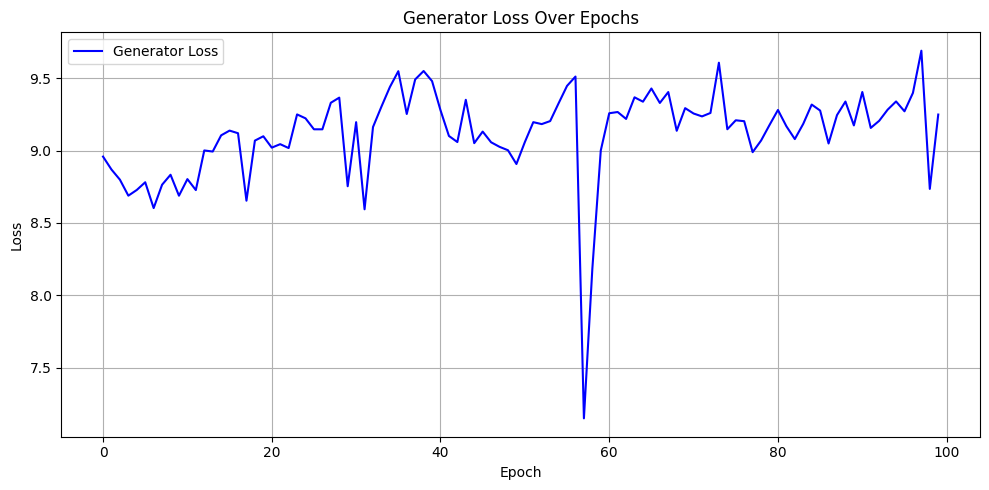

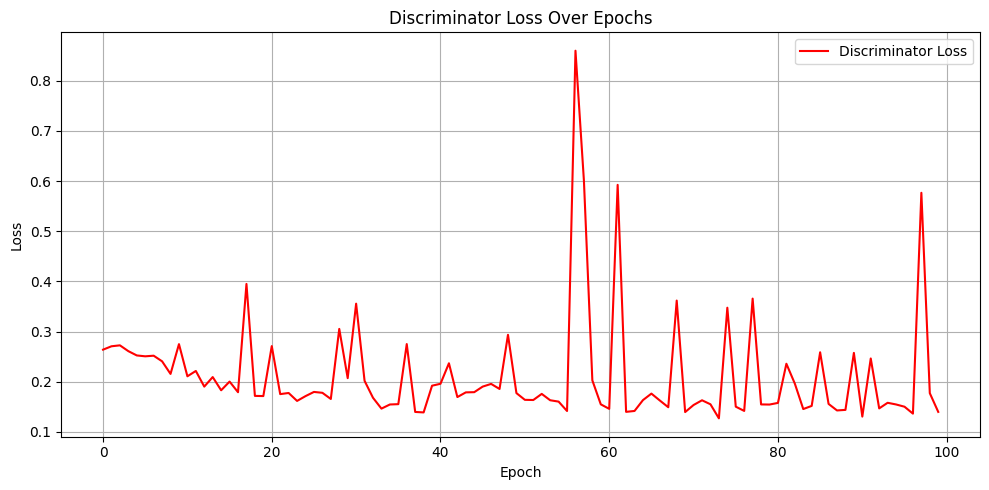

<function matplotlib.pyplot.show(close=None, block=None)>

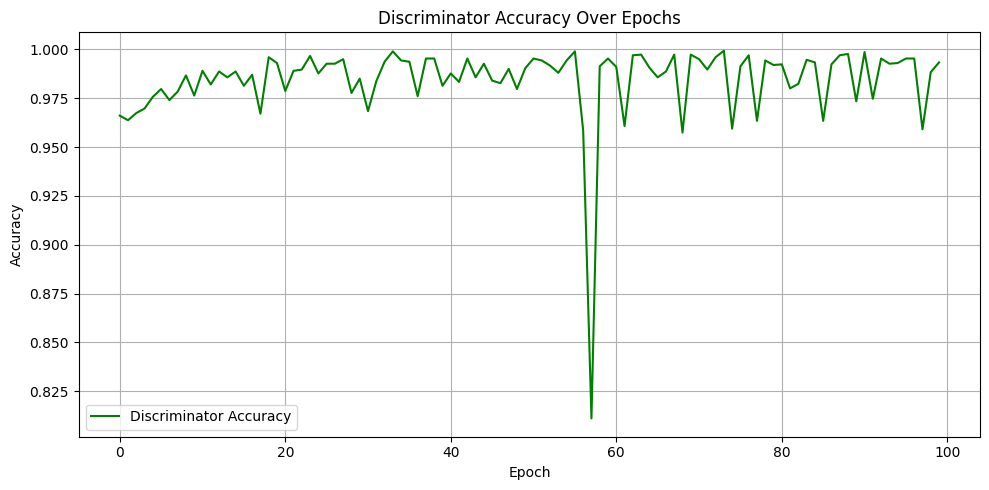

In [38]:
import matplotlib.pyplot as plt

# Plot Generator Loss
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Discriminator Loss
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(d_accuracies, label="Discriminator Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Discriminator Accuracy Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show

In [ ]:

print(f"Total training samples: {len(dataset)}")


In [24]:
pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 8.2 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 5.7 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn]0m 3/4 [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


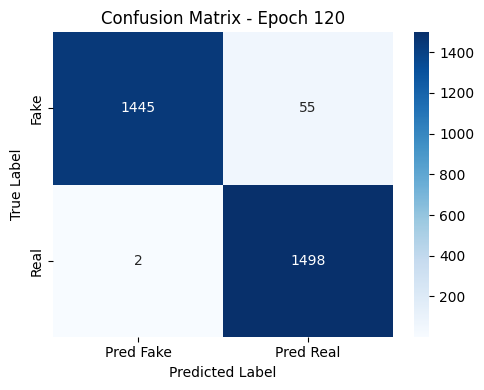

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replace with your desired epoch
epoch = 120

# Load confusion matrix CSV
cm_df = pd.read_csv(f"../experiments/exp2/logs/confusion_epoch_{epoch}.csv", index_col=0)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - Epoch {epoch}")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

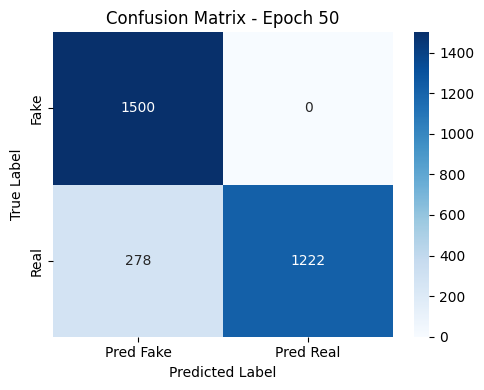

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replace with your desired epoch
epoch = 50

# Load confusion matrix CSV
cm_df = pd.read_csv(f"../experiments/exp2/logs/confusion_epoch_{epoch}.csv", index_col=0)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - Epoch {epoch}")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

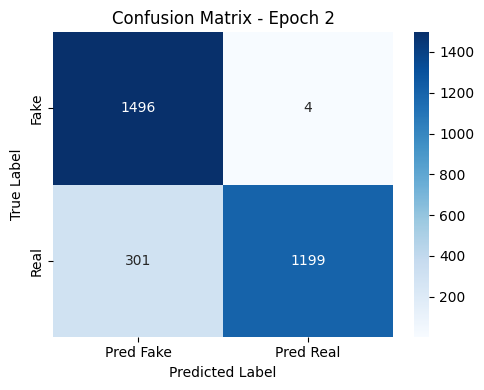

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replace with your desired epoch
epoch = 2

# Load confusion matrix CSV
cm_df = pd.read_csv(f"../experiments/exp2/logs/confusion_epoch_{epoch}.csv", index_col=0)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - Epoch {epoch}")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

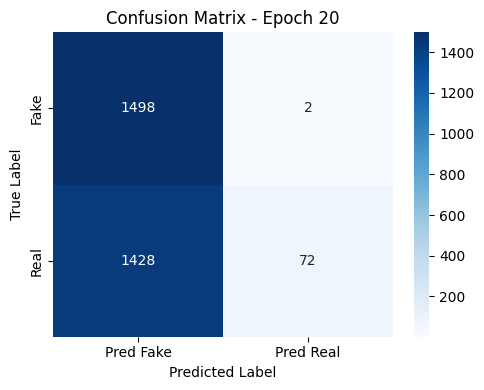

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replace with your desired epoch
epoch = 20

# Load confusion matrix CSV
cm_df = pd.read_csv(f"../experiments/exp2/logs/confusion_epoch_{epoch}.csv", index_col=0)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - Epoch {epoch}")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

In [45]:
print(g_losses)


[11.376792697196311, 8.853361794289123, 8.523944953654675, 8.207912670805099, 7.896433901279531, 7.707728827253301, 7.444103963831638, 7.391596964065065, 7.230692247126965, 7.151958924658755, 7.098088008292178, 7.0179071248845855, 7.000521959142482, 6.9390807303976505, 6.971039635069827, 6.854850611788161, 6.939046555377067, 7.163378028159446, 8.457817245036997, 8.975590525789464, 8.705112462348126, 8.513844594042352, 8.529305100440979, 8.563875134955062, 8.602043765656491, 8.438090608475056, 8.561252931331067, 8.490793438667946, 8.485670609677092]
